In [43]:
import numpy as np
import matplotlib.pyplot as plt
import elephant
import quantities as pq
import neo
import viziphant
import os


## Overview: 
This jupyter noteboook is a basic python implementation of the SIMNETS neural analysis framework[1].
- A more efficent and versality python implementation can be found on the Donoghue/ Vargas-Irwin lab GitHub Page, [3], created by Nick Tolley. 
- For an C++ optimized Matlab toolbox, see [2] on the Donoghue/ Vargas-Irwin lab GitHub Page. 

###### WHAT
The SIMNETS analysis is an unsupervised method for generating and visualizing the latent Computational Similarity (CS) relationships among a population of simultaneously recording individual neurons.  The document provides a comprehensive guide on the various steps involved in the most basic algorithmic implementation of the SIMNETS Analysis. The code can serve as a starting point for researchers interested in analyzing neural data and can be easily adapted to fit specific experimental paradigms. A faster python implementation with greater functionality may be found here: https://github.com/DonoghueLab/SIMNETS-Python. 

###### WHY
As is demonstrated in this tutorial, the resulting low-dimensional CS maps of the population of neurons can facilitate the identification of CS neuron clusters, or putative computational subnetworks. These CS neurons maps are a powerful and efficent tool for conducing preliminary exploratory analyses within very large-scale neural recording datasets. For example, the Matlab toolbox can rapidly (milliseconds) seperate (i.e., clusters) groups of noisy or uninformative neuron from those encoding useful neural signals. 

##### SECTION A: STEPS
- STEP 1: This code is organized into different sections, starting with setting up the necessary simulation parameters to create a small dataset of sysynthetic spike trains.

- STEP 2: We then use a distance metric (victor purpura metric) to calculate the geometry of each neurons spike train output space (i.e., its computational geometry or representational geometry). 

- STEP 3: The neuron-wise Computational Similarity Scores are calculate for all NxN neuron pairs using pearson's correlation (pros: fast/efficient, cons: linear method, senstive to outliers). 

- STEP 4: The code then calculates low-dimensional projections of the NxN CS matrix using t-SNE, a popular technique for visualizing high-dimensional data. 

- STEP 5: We the use the k-means clustering algorithm to identify clusters of computationally similar neurons. 

- STEP 6: This document also includes single neuron raster plots and the single neuron spike train dissimilarity matrices (SSIM matrices). The document also includes plots of high and low-dimensional CS matrices and maps to visualize the results. 

- STEP 7: Computational cluster detection: unsupervised neuron cluster detection

##### SECTION B: In Progress...
  
    - STEP 8: Parallelization: Computational Complexity & run-time analysis with & without parallelization

    - STEP 9: Method Comparison: SIMNETS Vs. Cross-Correlation: similarities & differences 




##### RESOURCES/CITATIONS

[1] Mapping the Computational Similarity of Individual neurons within large-scale ensemble recordings usingthe SIMNETS analysis framework. elife, Tools & Resources (in-review). Hynes, JB., Brand man, D., Zimmerman, J., Donoghue, J., Vargas-Irwin, C. doi: doi.org/10.1101/463364

[2] Matlab ToolBox: https://github.com/DonoghueLab/SIMNETS-Analysis-Toolbox 

[3] Python Toolbox(under development): https://github.com/DonoghueLab/SIMNETS-Python

[4] Elephant (doi:10.5281/zenodo.1186602; RRID:SCR_003833)
elephant electrophysiology analysistoolkit: a very useful and well-maintained codebase for analyzing neural data. Includes both classic signal processing tools/tutorials and more advanced neural analysis tools/tutorials. https://elephant.readthedocs.io/en/stable/tutorials/statistics.html 
www.python-elephant.org




##### Author: jacqueline_hynes@brown.edu, june 2023 
Contact: @author Jacqueline Hynes. Copyright (c) Jacqueline Hynes, Brown University. All rights reserved.
Questions? Contact <Carlos Vargas_irwin@brown.edu>  or <Jacqueline Hynes@Brown.edu>. We are happy to help with any trouble shooting or provide guidance on how to best analyze your own data.




## Section A: 

### 1.0. Creating a dataset of synthetic spike trains
We start by setting up the necessary simulation parameters to create a small dataset of sysynthetic spike trains. These parameters include the number of neurons, the number of stimulus conditions, and the number of trials per stimulus condition.
- num_neurons: number of neurons in the test population
- num_trials_cond/num_trials: the code is currently set up to simulate 20 spiketrains per neurons (5 repeats per   stimulus conditions)

We also set the parameters for the general SIMNETS analysis, which include:
- q: the VP spike train temporal accuracy settings 
- perp: the tSNE perplexity value, which is a paramter that defines a neuron's local neighbours 



In [44]:
from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
from quantities import ms, s, Hz
np.random.seed(28)  # to make the results reproducible


#1.0 Set-up parameters
win_start = 0        #  spike train start time 
win_stop = 1         # spike train length/ endtime

num_neurons = 6      # num neurons   
num_cond = 4         # stimulus condition
num_trials_cond = 5  # trials per stimulus condition

# These values specifes each neurons firing rates across the 'num_cond' conditions. 
rate_pop = [[70, 70, 70, 5],
            [30, 30, 30, 3], 
            [55, 55, 55, 3], 
            [10, 10, 30, 60], 
            [20, 20, 50, 80], 
            [15, 15, 25, 50]]
     
# Generate spike trains using encoding model of choice:
num_cond = len(rate_pop[0])
num_trials = num_trials_cond*num_cond
spks_population = []
spks_trials = []

for n in range(num_neurons):
    rate_ref = rate_pop[n]
    spks_trials = []
    
    for r in rate_ref:
        spks = [ homogeneous_poisson_process(rate=r*Hz, t_start=win_start*s, t_stop=win_stop*s) 
                for i in range(num_trials_cond) ]
        
        spks_trials.append(spks) 
    spks_trials = np.array([spks_trials], dtype = object) 
    spks_trials = np.resize(spks_trials, (num_trials,))
    spks_population.append(spks_trials)

spks_population = np.array(spks_population)
print(f'neurons & trials {spks_population.shape}')     # Population: [rows, cols]  = [neurons, trials] 
print(f'trials per neuron {spks_population[0].shape}') # Single neuron: [rows, cols]  = [neurons, trials] 
 

 

neurons & trials (6, 20)
trials per neuron (20,)


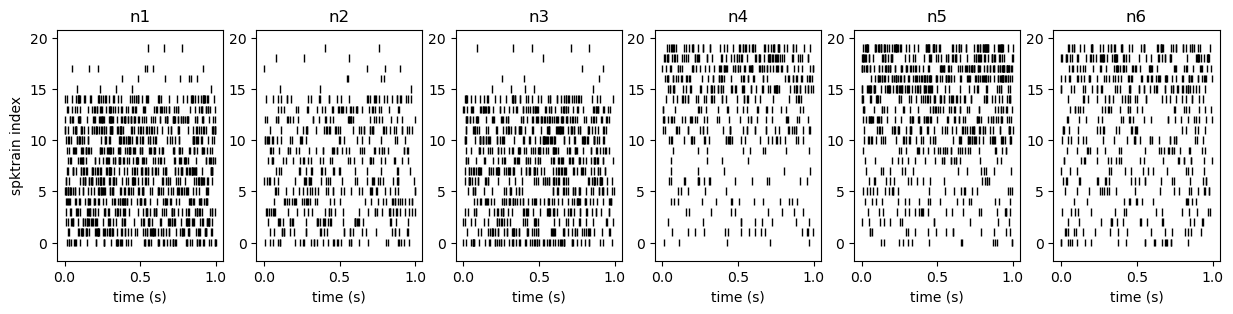

<Figure size 3200x2400 with 0 Axes>

In [45]:
# Plot single neuron raster plots for the synthetic data
fig, axs = plt.subplots(1,num_neurons, figsize=(7,3))
fig.set_figwidth(15) 
plt.figure(dpi=500)
axs[0].set_ylabel('spktrain index') 
 
for n in range(num_neurons):
    
    # Plot Single Neuron Raster Plots 
    axs[n].eventplot([st.magnitude for st in spks_population[n]], linelengths=0.75, linewidths=1, color='black')
    axs[n].set_xlabel('time (s)') 
    axs[n].set_title('n' + str(int(n+1))) 

### 2.0.  Generate a Single Neuron Spike train Similarity Matrix (SSIM matrix) for each neuron. 
We then use a distance metric (victor purpura metric) to calculate the pairwise spiketrain similarities among the spiketrains of each neurons. Each neuron's SxS matrix of spiketrain distances capture the geometry of each neurons output space, i.e., the computational geometry or representational geometry. 

Although this is a computationally costly step,( SxS spike train comparisons per neuron), it fortunately can be parallelized, i.e., each single neuron SSIM matrix is independently computed across nodes. Future versions of this tutorial will implement this parallelization (Section 


#### Decisions: spike train similiarity metric and associated parameters

- Discrete signals: The Victor Purpura method is a good choice for discrete neural signals (point-process time series). The q value discates the temporal accuracy of the methods. When q = 0, the VP spike train distances reflect spike count differences and define a euclidean space, when q >0 (increasing temporal resolution) VP spike train distances reflect the temporal difference among a neurons spike train and defines a non-euclidean spaces. Euclidean spaces are more amenable to classic signal processing techniques, but sometimes non-euclidean spaces needed for capturing non-linear perceptual manifolds). 

- Continuous signals: The Von Rossum metric is useful when working with continuous signals (e.g., spike power, LFP signals, EEG signals).  

In [46]:
import neo
from elephant.spike_train_dissimilarity import victor_purpura_distance

q = 10/ (10.0 * pq.ms)  # Temporal accuracy of Victor-Purpura similarity metric
print(q)


ssimdist_pop = []
spkdist_vec = [] 
for n in range(num_neurons):
    
    spkdist_vec = []
    
    for sx in range(num_trials):
        
        for sy in range(num_trials):   # Efficiency note:only calculate the lower side of matrix (while sy<sx), then duplicate to upper.  
                
            spkdist = victor_purpura_distance([spks_population[n,sx], spks_population[n,sy]], q, algorithm='fast')[0, 1]
            spkdist_vec.append(spkdist)      
    ssimdist_pop.append(spkdist_vec)
       
ssimdist_pop = np.array(ssimdist_pop) 
print(ssimdist_pop.shape)

1.0 1/ms
(6, 400)


Text(0.5, 0, 'spktrain index')

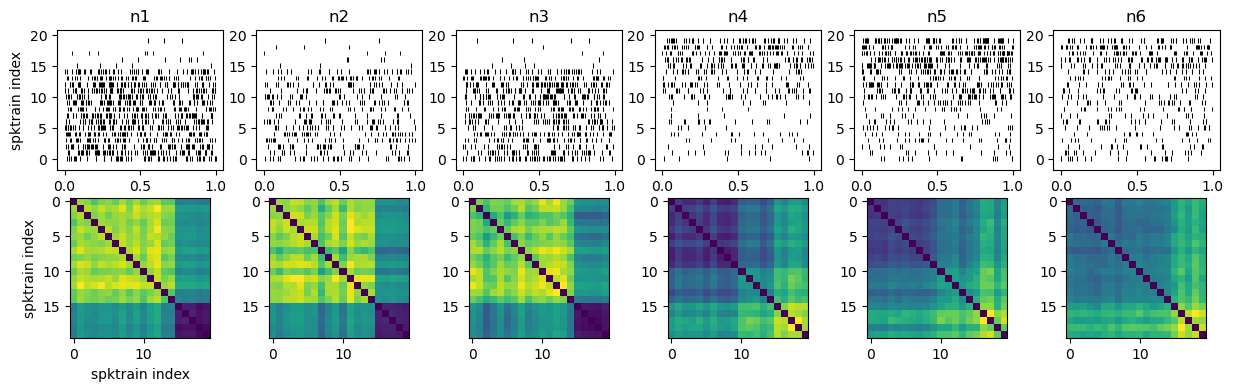

<Figure size 3200x2400 with 0 Axes>

In [47]:
# Plotting: Single neuron rasters and Single neuron ssim matrices
fig, axs = plt.subplots(2,num_neurons, figsize=(7,4))
fig.set_figwidth(15) 
plt.figure(dpi=500)

for n in range(num_neurons):
    
    # Plot Single Neuron Raster Plots 
    axs[0,n].eventplot([st.magnitude for st in spks_population[n]], linelengths=0.75, linewidths=0.75, color='black')
    axs[0,n].set_xlabel('time (s)') 
    axs[0,n].set_title('n' + str(int(n+1))) 
    
    # Plot Single Neuron Raster Plots 
    ssimMat = np.reshape(ssimdist_pop[n], [num_trials, num_trials])
    axs[1,n].imshow(ssimMat)     
     
axs[0,0].set_ylabel('spktrain index') 
axs[1,0].set_ylabel('spktrain index')
axs[1,0].set_xlabel('spktrain index')

### STEP 3-4: measure the pairwise CS score among all neurons to generate a NxN CS matrix for the neuron population, then use tSNE the generate a low-dimension dxN CS matrix. 


The neuron-wise Computational Similarity Scores are calculate for all NxN pairs of neurons. Any neuron similarity metric/measure can be used to assess the similarities of the neuron SSIM matrices. Here we use Pearson's correlation as our meausure of Computational Simliliarty, however, many different measures are appropriate. 
- Pearson's r:
    - Pros: fast/efficient; 
    - Cons: a senstivity to outliers; it is a linear method and will not capture non-linear relationships amongthe neurons SSIM matrices. 

We then use t-SNE to generate a low-dimensional projection of the NxN CS map. tSNE is a local, non-linear method that preserves the local relationships between the neurons during the mapping, where the local neighbourhood is defined by tSNE

In [48]:
from elephant.spike_train_correlation import correlation_coefficient
import scipy.stats
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

perp = num_neurons//2   # Perplexity value for tSNE (i.e., # of neurons within a local neighbourbood)



# We calculate the Computational Similarity between all NxN neurons:
cs_matrix = []
for nx in range(num_neurons):
    
    for ny in range(num_neurons):
        r = scipy.stats.pearsonr(ssimdist_pop[nx,:],ssimdist_pop[ny,:])
        cs_matrix.append(r.correlation)

cs_matrix = np.resize(cs_matrix, (num_neurons,num_neurons))
print(cs_matrix.shape)


# We calculate the low-dimensional projections of the NxN CS matrix
tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=500)
cs_lowdim = tsne.fit_transform(cs_matrix)



(6, 6)
[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1.983320
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.799091
[t-SNE] KL divergence after 500 iterations: 0.004308


NameError: name 'axmap' is not defined

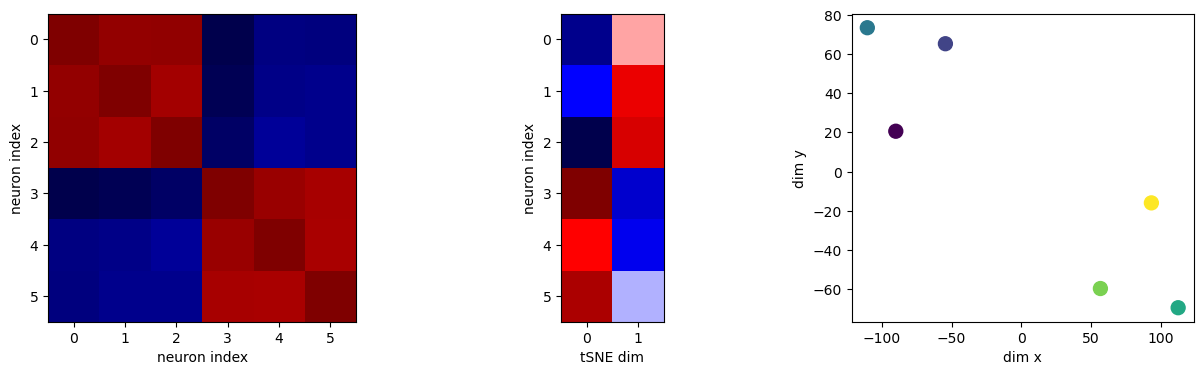

<Figure size 3200x2400 with 0 Axes>

In [49]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd 
neuronid = [ 1, 2, 3, 4, 5, 6]

# Plotting: high matrices 
fig1, axs1 = plt.subplots(1,3, figsize=(7,4))
fig1.set_figwidth(15) 
plt.figure(dpi=500)
axs1[0].imshow(cs_matrix, cmap='seismic' )  
axs1[0].set_ylabel('neuron index') 
axs1[0].set_xlabel('neuron index') 


# Plotting: low-dim CS matrix 
axs1[1].imshow(cs_lowdim, cmap='seismic' )  
axs1[1].set_xlabel('tSNE dim') 
axs1[1].set_ylabel('neuron index') 


# Plotting: low-dim CS map 
axs1[2].scatter(cs_lowdim[:,0], cs_lowdim[:,1], c=neuronid, s=100)
axs1[2].set_xlabel ('dim x')
axs1[2].set_ylabel ('dim y')
 
legend1 = axs1[2].legend(*[axmap.legend_elements()[0],neuronid], title="neuron id", loc='upper right')
 
axs1[2].set_xticks([])
axs1[2].set_yticks([])
plt.show()

## In Progress Beyond This Point.....
conversion in progress

### STEP 7: Computational cluster detection: unsupervised neuron cluster detection
Output Characterization:  cluster detection, silhouette analysis,  k-means clustering, significance testing
Use k-means clustering tool to cluster neurons in to 'k' cluster, where an optimal k value is calculated using a silhouette analysis. The larger the avg. silhouette value for a given value of k, the better the cluster solution. 


In [ ]:



# crange =10
   
#[ silhouette, clusterindex, nclus  ] = autokmeanscluster( crange , cs_lowdim );
 
#[SC,  kNum] = max(silhouette);

# Shulffle-Based Significicance Test of Silhouette Value. 
# Uncomment and set iterations to >1.  This step is skipped if iterations = 0. 

# [ ncmatShift, shufMU, shufCI] = SSIMSNeuronRelCorr_shuffleTest( SSIMmats, iterations, perplexity );   % Example Varargin: plotting dimensions, cluster number, corrType, perplexity

#Cluster Validation: Silhouette Plot
#figure
#plot(2:max(crange), silhouette(2:max(crange)),'ko-', 'linewidth', 1.5);hold on; 
#plot(kNum, SC,'ro', 'markersize',15);
#ylim([0 1])

 
 
#xlabel('cluster Number')
#ylabel('mean sil. values')   
#xlim([ 2 max(crange)])
#set(gcf, 'position',[ 680   855   426   243]);
#set(gca,'linewidth',2)
#title([ 'Cluster Identification: Silhouette Plot - showing optimal cluster number = ' num2str(kNum) ])


## Section B: 

### Optional : Compute Time: run-time analysis with & without parallelization


### STEP 9: SIMNETS Vs. Cross-Correlation: similarities & differences